In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_list, size, count, when, explode, split, regexp_extract, udf ,to_timestamp, lit
from pyspark.sql.types import StructType, StructField, StringType
import re
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Log_analysis") \
    .master("spark://spark-master:7077") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

spark


In [3]:
LOG_PATH = 'hdfs://namenode:9000/user/root/data/tmp/datack/HDFS.log'
TEMPLATES_PATH = 'hdfs://namenode:9000/user/root/data/tmp/HDFS.log_templates.csv'
LABEL_PATH = 'hdfs://namenode:9000/user/root/data/tmp/anomaly_label.csv'
df_raw = spark.read.text(LOG_PATH)
df_templates = spark.read.csv(TEMPLATES_PATH,header=True, inferSchema=True)
df_label = spark.read.csv(LABEL_PATH,header=True, inferSchema=True)
# /user/root/data/tmp/HDFS.log_templates.csv
# /user/root/data/tmp/anomaly_label.csv

In [4]:
df_raw.show(5, truncate=False)
df_templates.show(5,truncate=False)
df_label.show(5,truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                     |
+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|081109 203518 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010            |
|081109 203518 35 INFO dfs.FSNamesystem: BLOCK* NameSystem.allocateBlock: /mnt/hadoop/mapred/system/job_200811092030_0001/job.jar. blk_-1608999687919862906|
|081109 203519 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.10.6:40524 dest: /10.250.10.6:50010                |
|081109 203519 145 INFO dfs.DataNode$DataXceiver: Receivin

In [5]:
patterns = {
    "timestamp": r"(\d{6}\s+\d{6})",  # 081109 203518
    "pid": r"\d{6}\s+\d{6}\s+(\d+)",  # process id (143)
    "level": r"(INFO|WARN|ERROR|DEBUG)",
    "component": r"(?:INFO|WARN|ERROR|DEBUG)\s+([A-Za-z0-9\$\.\*]+):",
    "message": r"(?:INFO|WARN|ERROR|DEBUG)\s+[A-Za-z0-9\$\.\*]+:\s*(.*)",
    "BlockId": r"(blk_[\-0-9]+)",
}
for col_name, pattern in patterns.items():
    df_raw = df_raw.withColumn(col_name, regexp_extract(col("value"), pattern, 1))

df_raw.show(5)

+--------------------+-------------+---+-----+--------------------+--------------------+--------------------+
|               value|    timestamp|pid|level|           component|             message|             BlockId|
+--------------------+-------------+---+-----+--------------------+--------------------+--------------------+
|081109 203518 143...|081109 203518|143| INFO|dfs.DataNode$Data...|Receiving block b...|blk_-160899968791...|
|081109 203518 35 ...|081109 203518| 35| INFO|    dfs.FSNamesystem|BLOCK* NameSystem...|blk_-160899968791...|
|081109 203519 143...|081109 203519|143| INFO|dfs.DataNode$Data...|Receiving block b...|blk_-160899968791...|
|081109 203519 145...|081109 203519|145| INFO|dfs.DataNode$Data...|Receiving block b...|blk_-160899968791...|
|081109 203519 145...|081109 203519|145| INFO|dfs.DataNode$Pack...|PacketResponder 1...|blk_-160899968791...|
+--------------------+-------------+---+-----+--------------------+--------------------+--------------------+
only showi

In [6]:
df_raw = df_raw.withColumn("datetime", to_timestamp(col("timestamp"), "yyMMdd HHmmss"))
df_raw.show(5)

+--------------------+-------------+---+-----+--------------------+--------------------+--------------------+-------------------+
|               value|    timestamp|pid|level|           component|             message|             BlockId|           datetime|
+--------------------+-------------+---+-----+--------------------+--------------------+--------------------+-------------------+
|081109 203518 143...|081109 203518|143| INFO|dfs.DataNode$Data...|Receiving block b...|blk_-160899968791...|2008-11-09 20:35:18|
|081109 203518 35 ...|081109 203518| 35| INFO|    dfs.FSNamesystem|BLOCK* NameSystem...|blk_-160899968791...|2008-11-09 20:35:18|
|081109 203519 143...|081109 203519|143| INFO|dfs.DataNode$Data...|Receiving block b...|blk_-160899968791...|2008-11-09 20:35:19|
|081109 203519 145...|081109 203519|145| INFO|dfs.DataNode$Data...|Receiving block b...|blk_-160899968791...|2008-11-09 20:35:19|
|081109 203519 145...|081109 203519|145| INFO|dfs.DataNode$Pack...|PacketResponder 1...|bl

In [7]:
df_raw = df_raw.select(
    "datetime", "pid", "level", "component", "message", "BlockId"
)
df_raw.show(5, truncate=False)


+-------------------+---+-----+----------------------------+------------------------------------------------------------------------------------------------------------------+------------------------+
|datetime           |pid|level|component                   |message                                                                                                           |BlockId                 |
+-------------------+---+-----+----------------------------+------------------------------------------------------------------------------------------------------------------+------------------------+
|2008-11-09 20:35:18|143|INFO |dfs.DataNode$DataXceiver    |Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010                     |blk_-1608999687919862906|
|2008-11-09 20:35:18|35 |INFO |dfs.FSNamesystem            |BLOCK* NameSystem.allocateBlock: /mnt/hadoop/mapred/system/job_200811092030_0001/job.jar. blk_-1608999687919862906|blk_-1608999687919862

In [8]:
def template_to_regex(tmpl):
    # Escape tất cả ký tự đặc biệt để an toàn
    escaped = re.escape(tmpl)
    # Thay thế [*] (sau khi escape sẽ thành \[\*\]) bằng .*
    regex = escaped.replace(r"\[\*\]", ".*")
    return regex

df_parsed = df_raw.withColumn("EventId", lit(None))

for row in df_templates.collect():
    eid = row["EventId"]
    tmpl = row["EventTemplate"]
    pattern = template_to_regex(tmpl)
    
    df_parsed = df_parsed.withColumn(
        "EventId",
        when(col("message").rlike(pattern), eid).otherwise(col("EventId"))
    )

df_parsed.select("datetime", "component", "message", "BlockId", "EventId").show(truncate=False)

+-------------------+----------------------------+------------------------------------------------------------------------------------------------------------------------+------------------------+-------+
|datetime           |component                   |message                                                                                                                 |BlockId                 |EventId|
+-------------------+----------------------------+------------------------------------------------------------------------------------------------------------------------+------------------------+-------+
|2008-11-09 20:35:18|dfs.DataNode$DataXceiver    |Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010                           |blk_-1608999687919862906|E5     |
|2008-11-09 20:35:18|dfs.FSNamesystem            |BLOCK* NameSystem.allocateBlock: /mnt/hadoop/mapred/system/job_200811092030_0001/job.jar. blk_-1608999687919862906      |blk_-1608

In [9]:
# Sắp xếp theo thời gian trong từng Block
windowSpec = Window.partitionBy("BlockId").orderBy("datetime")

# Gom theo BlockId và thu danh sách EventId
event_traces = (
    df_parsed
    .filter(F.col("EventId").isNotNull())   # bỏ dòng chưa map được event
    .groupBy("BlockId")
    .agg(
        F.collect_list("EventId").alias("EventSequence")
    )
    .cache()
)
event_traces.show(truncate=False)

+------------------------+-----------------------------------------------------------------------------------------------------------------------------------------+
|BlockId                 |EventSequence                                                                                                                            |
+------------------------+-----------------------------------------------------------------------------------------------------------------------------------------+
|blk_-1001138135617662562|[E22, E5, E5, E5, E11, E9, E11, E9, E26, E26, E26, E11, E9, E3, E3, E4, E3, E3, E4, E23, E23, E23, E3, E3, E4, E3, E3, E4, E21, E21, E21]|
|blk_-1005590426013980840|[E23, E23, E23, E21, E21, E21, E5, E5, E22, E5, E11, E9, E11, E9, E11, E9, E26, E26, E26]                                                |
|blk_-102130907746974051 |[E23, E23, E23, E21, E5, E5, E5, E22, E11, E9, E11, E9, E11, E9, E26, E26, E26, E21, E21]                                                |
|blk_-1024

In [10]:
# Giả sử df có 2 cột: BlockId, EventSequence (array of strings)
event_ids = [f"E{i}" for i in range(1, 30)]  # E1..E30 

# Với mỗi event E, đếm số lần xuất hiện trong EventSequence
for eid in event_ids:
    event_traces = event_traces.withColumn(eid, F.expr(f"aggregate(filter(EventSequence, x -> x = '{eid}'), 0, (acc, x) -> acc + 1)"))

# Bỏ cột EventSequence nếu muốn
df_features = event_traces.drop("EventSequence")

df_features.show(truncate=False)

+------------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|BlockId                 |E1 |E2 |E3 |E4 |E5 |E6 |E7 |E8 |E9 |E10|E11|E12|E13|E14|E15|E16|E17|E18|E19|E20|E21|E22|E23|E24|E25|E26|E27|E28|E29|
+------------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|blk_-1001138135617662562|0  |0  |8  |4  |3  |0  |0  |0  |3  |0  |3  |0  |0  |0  |0  |0  |0  |0  |0  |0  |3  |1  |3  |0  |0  |3  |0  |0  |0  |
|blk_-1005590426013980840|0  |0  |0  |0  |3  |0  |0  |0  |3  |0  |3  |0  |0  |0  |0  |0  |0  |0  |0  |0  |3  |1  |3  |0  |0  |3  |0  |0  |0  |
|blk_-102130907746974051 |0  |0  |0  |0  |3  |0  |0  |0  |3  |0  |3  |0  |0  |0  |0  |0  |0  |0  |0  |0  |3  |1  |3  |0  |0  |3  |0  |0  |0  |
|blk_-1024067452279512003|0  |0  |0  |0  |3  |0  |0  |0  |3  |0  |3  |0  |0  |0  |0  |0  |0  |0  |0  |0  |0  |1  |0  |0  |0  |3  |0  |0  |0  |

In [11]:
df_final = df_features.join(df_label, on="BlockId", how="left")

In [12]:
df_final.show(5)

+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+
|             BlockId| E1| E2| E3| E4| E5| E6| E7| E8| E9|E10|E11|E12|E13|E14|E15|E16|E17|E18|E19|E20|E21|E22|E23|E24|E25|E26|E27|E28|E29| Label|
+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+
|blk_-100113813561...|  0|  0|  8|  4|  3|  0|  0|  0|  3|  0|  3|  0|  0|  0|  0|  0|  0|  0|  0|  0|  3|  1|  3|  0|  0|  3|  0|  0|  0|Normal|
|blk_-100559042601...|  0|  0|  0|  0|  3|  0|  0|  0|  3|  0|  3|  0|  0|  0|  0|  0|  0|  0|  0|  0|  3|  1|  3|  0|  0|  3|  0|  0|  0|Normal|
|blk_-102130907746...|  0|  0|  0|  0|  3|  0|  0|  0|  3|  0|  3|  0|  0|  0|  0|  0|  0|  0|  0|  0|  3|  1|  3|  0|  0|  3|  0|  0|  0|Normal|
|blk_-102406745227...|  0|  0|  0|  0|  3|  0|  0|  0|  3|  0|  3|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|  0|  0|  

In [ ]:
indexer = StringIndexer(inputCol="Label", outputCol="label_index")
df_final = indexer.fit(df_final).transform(df_final)

In [14]:
df_final.show(5)

+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----------+
|             BlockId| E1| E2| E3| E4| E5| E6| E7| E8| E9|E10|E11|E12|E13|E14|E15|E16|E17|E18|E19|E20|E21|E22|E23|E24|E25|E26|E27|E28|E29| Label|label_index|
+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----------+
|blk_-100113813561...|  0|  0|  8|  4|  3|  0|  0|  0|  3|  0|  3|  0|  0|  0|  0|  0|  0|  0|  0|  0|  3|  1|  3|  0|  0|  3|  0|  0|  0|Normal|        0.0|
|blk_-100559042601...|  0|  0|  0|  0|  3|  0|  0|  0|  3|  0|  3|  0|  0|  0|  0|  0|  0|  0|  0|  0|  3|  1|  3|  0|  0|  3|  0|  0|  0|Normal|        0.0|
|blk_-102130907746...|  0|  0|  0|  0|  3|  0|  0|  0|  3|  0|  3|  0|  0|  0|  0|  0|  0|  0|  0|  0|  3|  1|  3|  0|  0|  3|  0|  0|  0|Normal|        0.0|
|blk_-102406745227...|  0|  0|  0|  0|  3|  0|  0|  

In [15]:
df_final = (
    df_final
    .withColumn("label_index", F.col("label_index").cast("integer"))  # ép kiểu int
    .drop("Label")  # xóa cột chữ
)
df_final.show(5)

+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+-----------+
|             BlockId| E1| E2| E3| E4| E5| E6| E7| E8| E9|E10|E11|E12|E13|E14|E15|E16|E17|E18|E19|E20|E21|E22|E23|E24|E25|E26|E27|E28|E29|label_index|
+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+-----------+
|blk_-100113813561...|  0|  0|  8|  4|  3|  0|  0|  0|  3|  0|  3|  0|  0|  0|  0|  0|  0|  0|  0|  0|  3|  1|  3|  0|  0|  3|  0|  0|  0|          0|
|blk_-100559042601...|  0|  0|  0|  0|  3|  0|  0|  0|  3|  0|  3|  0|  0|  0|  0|  0|  0|  0|  0|  0|  3|  1|  3|  0|  0|  3|  0|  0|  0|          0|
|blk_-102130907746...|  0|  0|  0|  0|  3|  0|  0|  0|  3|  0|  3|  0|  0|  0|  0|  0|  0|  0|  0|  0|  3|  1|  3|  0|  0|  3|  0|  0|  0|          0|
|blk_-102406745227...|  0|  0|  0|  0|  3|  0|  0|  0|  3|  0|  3|  0|  0|  0|  0|  0|  0|  0|

In [16]:
features = [f"E{i}" for i in range(1, 30)]
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_vector = assembler.transform(df_final)

In [17]:
df = df_vector.select("features", "label_index", "BlockId" )


In [18]:
df.show(5)

+--------------------+-----------+--------------------+
|            features|label_index|             BlockId|
+--------------------+-----------+--------------------+
|(29,[2,3,4,8,10,2...|          0|blk_-100113813561...|
|(29,[4,8,10,20,21...|          0|blk_-100559042601...|
|(29,[4,8,10,20,21...|          0|blk_-102130907746...|
|(29,[4,8,10,21,25...|          0|blk_-102406745227...|
|(29,[4,8,10,21,25...|          0|blk_-102748718171...|
+--------------------+-----------+--------------------+
only showing top 5 rows



In [19]:
test_size = 0.2

# Lấy tất cả nhãn (kể cả đa lớp)
labels = [r['label_index'] for r in df.select('label_index').distinct().collect()]
fractions_test = {int(l): test_size for l in labels}

test = df.sampleBy('label_index', fractions=fractions_test, seed=42)
train = df.join(test.select('BlockId'), on='BlockId', how='left_anti')  # phần còn lại

In [20]:
cnt = (train.groupBy("label_index").count()
             .withColumnRenamed("count","n"))
N = cnt.agg(F.sum("n")).first()[0]
K = cnt.count()

w_map = (cnt
         .withColumn("weight_class", F.lit(float(N)) / (F.lit(float(K)) * F.col("n")))
         .select("label_index","weight_class"))

train_w = train.join(w_map, on="label_index", how="left").withColumnRenamed("weight_class","weight")
test_w  = test.join(w_map,  on="label_index", how="left").withColumnRenamed("weight_class","weight")

In [21]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [22]:
bin_eval = BinaryClassificationEvaluator(labelCol="label_index", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
multi_eval = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="f1")

In [23]:
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label_index",
    weightCol="weight",
    maxIter=200,
    regParam=0.01,          
    elasticNetParam=0.0,    
    standardization=True
)


In [24]:
def train_and_eval(train_df, test_df, evaluator, metric_name, fraction=1.0):
    """Train LR trên 1 fraction của train_df, trả về (train_metric, test_metric)."""
    sample = train_df.sample(withReplacement=False, fraction=fraction, seed=42)
    model = lr.fit(sample)
    
    # Tính metric trên tập train và test
    train_metric = evaluator.evaluate(model.transform(sample))
    test_metric = evaluator.evaluate(model.transform(test_df))
    
    print(f"Fraction={fraction:.1f} | Train {metric_name}: {train_metric:.4f} | Test {metric_name}: {test_metric:.4f}")
    return train_metric, test_metric



In [25]:
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
metrics = []
metric_name = "PR AUC"
for f in fractions:
    m_train, m_test = train_and_eval(train_w, test_w, bin_eval, metric_name, f)
    metrics.append((f, m_train, m_test))

Fraction=0.1 | Train PR AUC: 0.9124 | Test PR AUC: 0.9120
Fraction=0.2 | Train PR AUC: 0.8993 | Test PR AUC: 0.9119
Fraction=0.5 | Train PR AUC: 0.9093 | Test PR AUC: 0.9119
Fraction=0.8 | Train PR AUC: 0.9105 | Test PR AUC: 0.9115
Fraction=1.0 | Train PR AUC: 0.9129 | Test PR AUC: 0.9121


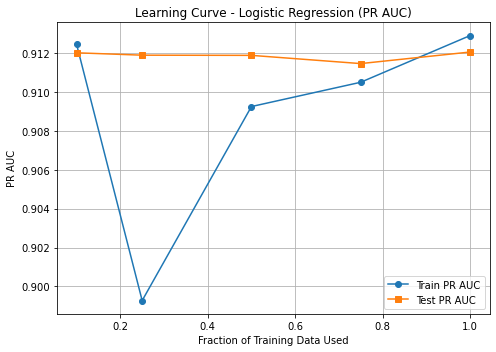

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

df_curve = pd.DataFrame(metrics, columns=["fraction", "train", "test"])

plt.figure(figsize=(7,5))
plt.plot(df_curve["fraction"], df_curve["train"], marker="o", label=f"Train {metric_name}")
plt.plot(df_curve["fraction"], df_curve["test"], marker="s", label=f"Test {metric_name}")
plt.xlabel("Fraction of Training Data Used")
plt.ylabel(metric_name)
plt.title(f"Learning Curve - Logistic Regression ({metric_name})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
df_save = spark.read.text(LOG_PATH)
df_save = (
    df_save.withColumn("date_str", F.regexp_extract("value", r"^(\d{6})", 1))         # 081109
      .withColumn("time_str", F.regexp_extract("value", r"^\d{6}\s+(\d{6})", 1)) # 203518
      .withColumn("BlockId", F.regexp_extract("value", r"(blk_[\-0-9]+)", 1))
      .filter(F.col("BlockId") != "")
)

# Chuyển YYMMDD + HHMMSS → timestamp thật
df_save = (
    df_save.withColumn(
        "datetime",
        F.to_timestamp(F.concat_ws(" ", F.col("date_str"), F.col("time_str")), "yyMMdd HHmmss")
    )
)
df_save.show(5)

+--------------------+--------+--------+--------------------+-------------------+
|               value|date_str|time_str|             BlockId|           datetime|
+--------------------+--------+--------+--------------------+-------------------+
|081109 203518 143...|  081109|  203518|blk_-160899968791...|2008-11-09 20:35:18|
|081109 203518 35 ...|  081109|  203518|blk_-160899968791...|2008-11-09 20:35:18|
|081109 203519 143...|  081109|  203519|blk_-160899968791...|2008-11-09 20:35:19|
|081109 203519 145...|  081109|  203519|blk_-160899968791...|2008-11-09 20:35:19|
|081109 203519 145...|  081109|  203519|blk_-160899968791...|2008-11-09 20:35:19|
+--------------------+--------+--------+--------------------+-------------------+
only showing top 5 rows



In [28]:
clean_line = F.concat(
    F.date_format(F.col("datetime"), "yyyy-MM-dd HH:mm:ss"),
    F.lit(" "),
    F.regexp_replace(F.col("value"), r"^\d{6}\s+\d{6}\s+", "")  # bỏ timestamp cũ ở đầu
).alias("clean_line")

In [29]:
# df_save = (
#     df_save.select("BlockId", "datetime", "value", clean_line)
#     .groupBy("BlockId")
#     .agg(
#         F.sort_array(F.collect_list(F.struct("datetime", "clean_line"))).alias("lines")
#     )
#     .withColumn("log_full", F.array_join(F.expr("transform(lines, x -> x.clean_line)"), "\n"))
#     .select("BlockId", "log_full")
#     .cache()
# )
agg = (
    df_save
    .select("BlockId", "datetime", "value", clean_line)
    .groupBy("BlockId")
    .agg(
        F.min("datetime").alias("start_ts"),
        F.max("datetime").alias("end_ts"),
        F.count("*").alias("num_lines"),  # 👈 Đếm số dòng log cho mỗi BlockId
        F.sort_array(
            F.collect_list(
                F.struct(F.col("datetime"), F.col("clean_line"))
            )
        ).alias("lines")  # gom & sắp xếp theo thời gian
    )
    .cache()
)

In [30]:
# df_save = (
#     df_save
#     .join(df_label.select("BlockId", "label"), on="BlockId", how="left")
#     .select("BlockId", "log_full", "label")
# )
df_save = (
    agg
    .withColumn("lines_sorted", F.expr("transform(lines, x -> x.clean_line)"))
    .withColumn("log_full", F.array_join(F.col("lines_sorted"), "\n"))
    .withColumn("duration_sec", F.col("end_ts").cast("long") - F.col("start_ts").cast("long"))
    .select("BlockId", "start_ts", "end_ts", "duration_sec", "log_full", "num_lines")
    .cache()
)

In [31]:

df_save = (
    df_save.join(df_label, on="BlockId", how="left")  # hoặc 'inner' nếu muốn khớp tuyệt đối
)

# Nếu bạn chỉ muốn giữ thêm cột 'label'
df_save = df_save.select(
    "BlockId", "start_ts", "end_ts", "duration_sec", "log_full", "num_lines", "label"
)

In [32]:
df_save.show(5)

+--------------------+-------------------+-------------------+------------+--------------------+---------+------+
|             BlockId|           start_ts|             end_ts|duration_sec|            log_full|num_lines| label|
+--------------------+-------------------+-------------------+------------+--------------------+---------+------+
|blk_-100113813561...|2008-11-10 01:19:42|2008-11-10 10:36:17|       33395|2008-11-10 01:19:...|       31|Normal|
|blk_-100559042601...|2008-11-11 07:07:19|2008-11-11 09:01:33|        6854|2008-11-11 07:07:...|       19|Normal|
|blk_-102130907746...|2008-11-11 02:54:37|2008-11-11 04:47:40|        6783|2008-11-11 02:54:...|       19|Normal|
|blk_-102406745227...|2008-11-11 09:00:23|2008-11-11 09:02:52|         149|2008-11-11 09:00:...|       13|Normal|
|blk_-102748718171...|2008-11-11 08:32:16|2008-11-11 08:32:51|          35|2008-11-11 08:32:...|       13|Normal|
+--------------------+-------------------+-------------------+------------+-------------

In [33]:
df_save_path = "hdfs://namenode:9000/data/logs_full_labeled.csv"


df_save.coalesce(1) \
    .write.mode("overwrite") \
    .option("header", True) \
    .csv(df_save_path)

print(f"✅ DataFrame saved to CSV at {df_save_path}")


df_final_path = "hdfs://namenode:9000/data/log_prepared.csv"

df_final.coalesce(1) \
    .write.mode("overwrite") \
    .option("header", True) \
    .csv(df_final_path)

print(f"✅ DataFrame saved to CSV at {df_final_path}")

# model_lr_v1_path = "hdfs://namenode:9000/data/lr_block_model_v1"
# model.write().overwrite().save(model_lr_v1_path)
# print(f"✅ Model saved to: {model_lr_v1_path}")

✅ DataFrame saved to CSV at hdfs://namenode:9000/data/logs_full_labeled.csv
✅ DataFrame saved to CSV at hdfs://namenode:9000/data/log_prepared.csv
